In [266]:

from scipy import stats
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from statsmodels import robust
import time


In [143]:
data = pd.read_csv('../data/cumulative_2022.04.28_05.30.33.csv', header=53)
print(f"Anzahl der KOI: {len(data['koi_disposition'])}")
print(
    f"Anzahl falsch positiver KOI: {len(data.loc[data['koi_disposition'] == 'FALSE POSITIVE'])}")
print(
    f"Anzahl der Kandidaten-KOI: {len(data.loc[data['koi_disposition'] == 'CANDIDATE'])}")
print(
    f"Anzahl der bestätigten KOI: {len(data.loc[data['koi_disposition'] == 'CONFIRMED'])}")
print(
    f"Basis-Rate: {len(data.loc[data['koi_disposition'] == 0])/len(data['koi_disposition'])}")
data.head()

# Aber in Excel-Datei von Kaggle sind 2248 Kandidaten, 2294 bestätigte und 5023 falsch positive.
# Ich habe jedoch die Daten vom NASA Exoplanet Archive genommen. https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative



Anzahl der KOI: 9564
Anzahl falsch positiver KOI: 4839
Anzahl der Kandidaten-KOI: 2057
Anzahl der bestätigten KOI: 2668
Basis-Rate: 0.0


kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0              0              0  ...   
3      0.000              0              1              0              0  ...   
4      1.000              0              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0           -81.0      4.467           0.064          -0.096     0.927   
1           -81.0      4.467           0.064          -0.096     0.927   
2          -176.0      4.544           0.044          -0.176     0.868   
3          -174.0      4.564           0.053          -0.168     0.791   
4          -211.0      4.438           0.070          -0.210     1.046   

   koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0          0.105         -0.061  291.93423  48.141651      15.347  
1          0.105         -0.061  291.93423  48.141651      15.347  
2          0.233         -0.078  297.00482  48.134129      15.436  
3          0.201         -0.067  285.53461  48.285210      15.597  
4          0.334         -0.133  288.75488  48.226200      15.509  

[5 rows x 49 columns]

In [144]:
# Pop the columns:
# Spalten mit "id" oder "name" im Namen enthalten nur Bezeichnungen. Die beiden "koi_teq_err"-Spalten sind leer.
to_pop = ["kepid", "kepoi_name", "kepler_name", "koi_teq_err1",
          "koi_teq_err2", "koi_tce_delivname"]

for col in to_pop:
    data.pop(col)

# Numerische Werte:
koi_disposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1, 'CONFIRMED': 2}
data["koi_disposition"] = data["koi_disposition"].replace(
    koi_disposition_dict)

koi_pdisposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1}
data["koi_pdisposition"] = data["koi_pdisposition"].replace(
    koi_pdisposition_dict)
data.head()



koi_disposition  koi_pdisposition  koi_score  koi_fpflag_nt  koi_fpflag_ss  \
0                2                 1      1.000              0              0   
1                2                 1      0.969              0              0   
2                1                 1      0.000              0              0   
3                0                 0      0.000              0              1   
4                2                 1      1.000              0              0   

   koi_fpflag_co  koi_fpflag_ec  koi_period  koi_period_err1  koi_period_err2  \
0              0              0    9.488036     2.775000e-05    -2.775000e-05   
1              0              0   54.418383     2.479000e-04    -2.479000e-04   
2              0              0   19.899140     1.494000e-05    -1.494000e-05   
3              0              0    1.736952     2.630000e-07    -2.630000e-07   
4              0              0    2.525592     3.761000e-06    -3.761000e-06   

   ...  koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0  ...           -81.0      4.467           0.064          -0.096     0.927   
1  ...           -81.0      4.467           0.064          -0.096     0.927   
2  ...          -176.0      4.544           0.044          -0.176     0.868   
3  ...          -174.0      4.564           0.053          -0.168     0.791   
4  ...          -211.0      4.438           0.070          -0.210     1.046   

   koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0          0.105         -0.061  291.93423  48.141651      15.347  
1          0.105         -0.061  291.93423  48.141651      15.347  
2          0.233         -0.078  297.00482  48.134129      15.436  
3          0.201         -0.067  285.53461  48.285210      15.597  
4          0.334         -0.133  288.75488  48.226200      15.509  

[5 rows x 43 columns]

In [145]:
knn_imputer = KNNImputer()

for column in data:

    data[column] = knn_imputer.fit_transform(
        data[column].to_numpy().reshape(-1, 1))

In [126]:
corr_pdisp = []
for col_index in range(0,43):
    corr_pdisp.append(stats.pearsonr(data[:, 1], data[:, col_index]))

    if abs(corr_pdisp[col_index][0]) >= 0.1:
        print(
            f"Korrelation von koi_pdisposition mit {col_names[col_index]}: {corr_pdisp[col_index]}")
    #print(f"Korrelation von koi_pdisposition mit {column}:  {stats.pearsonr(data['koi_pdisposition'],data[column])}")

#zip(col_index, (correlation[i][0] for i in range(0,43)))

Korrelation von koi_pdisposition mit koi_disposition: (0.9105929821633059, 0.0)
Korrelation von koi_pdisposition mit koi_pdisposition: (1.0, 0.0)
Korrelation von koi_pdisposition mit koi_score: (0.8206417014383628, 0.0)
Korrelation von koi_pdisposition mit koi_fpflag_ss: (-0.5383890794747113, 0.0)
Korrelation von koi_pdisposition mit koi_fpflag_co: (-0.489410423947375, 0.0)
Korrelation von koi_pdisposition mit koi_fpflag_ec: (-0.364346421931617, 4.18616620799342e-298)
Korrelation von koi_pdisposition mit koi_impact_err1: (-0.11391595439405457, 5.378987001200467e-29)
Korrelation von koi_pdisposition mit koi_duration: (-0.14442819858090522, 9.547758701949875e-46)
Korrelation von koi_pdisposition mit koi_depth: (-0.2703348931698425, 8.054739854394495e-160)
Korrelation von koi_pdisposition mit koi_teq: (-0.2963322440842985, 3.989205897501639e-193)
Korrelation von koi_pdisposition mit koi_model_snr: (-0.2480162831449162, 4.989341361018878e-134)
Korrelation von koi_pdisposition mit koi_tce_p

In [130]:
corr_disp = []
for col_index in range(0, 43):
    corr_disp.append(stats.pearsonr(data[:, 0], data[:, col_index]))

    if abs(corr_disp[col_index][0]) >= 0.1:
        print(
            f"Korrelation von koi_disposition mit {col_names[col_index]}: {corr_disp[col_index]}")
    #print(f"Korrelation von koi_pdisposition mit {column}:  {stats.pearsonr(data['koi_pdisposition'],data[column])}")

#zip(col_index, (correlation[i][0] for i in range(0,43)))


Korrelation von koi_disposition mit koi_disposition: (0.9999999999999959, 0.0)
Korrelation von koi_disposition mit koi_pdisposition: (0.9105929821633059, 0.0)
Korrelation von koi_disposition mit koi_score: (0.8473352157697137, 0.0)
Korrelation von koi_disposition mit koi_fpflag_ss: (-0.48848059950845785, 0.0)
Korrelation von koi_disposition mit koi_fpflag_co: (-0.4478050288288689, 0.0)
Korrelation von koi_disposition mit koi_fpflag_ec: (-0.33337287477622735, 5.842120486641862e-247)
Korrelation von koi_disposition mit koi_period_err1: (-0.1219394547818135, 5.2096808474842046e-33)
Korrelation von koi_disposition mit koi_period_err2: (0.1219394547818135, 5.2096808474842046e-33)
Korrelation von koi_disposition mit koi_impact_err1: (-0.12373969027521263, 5.999669667966453e-34)
Korrelation von koi_disposition mit koi_duration: (-0.15395502528186986, 8.232728893409177e-52)
Korrelation von koi_disposition mit koi_duration_err1: (-0.15120818932854865, 5.072931185526416e-50)
Korrelation von koi_

In [131]:
corr_score = []
for col_index in range(0, 43):
    corr_score.append(stats.pearsonr(data[:, 2], data[:, col_index]))

    if abs(corr_score[col_index][0]) >= 0.1:
        print(
            f"Korrelation von koi_score mit {col_names[col_index]}: {corr_score[col_index]}")
    #print(f"Korrelation von koi_pdisposition mit {column}:  {stats.pearsonr(data['koi_pdisposition'],data[column])}")

#zip(col_index, (correlation[i][0] for i in range(0,43)))


Korrelation von koi_score mit koi_disposition: (0.8473352157697137, 0.0)
Korrelation von koi_score mit koi_pdisposition: (0.8206417014383628, 0.0)
Korrelation von koi_score mit koi_score: (1.0, 0.0)
Korrelation von koi_score mit koi_fpflag_ss: (-0.4880688842452924, 0.0)
Korrelation von koi_score mit koi_fpflag_co: (-0.45277954331075654, 0.0)
Korrelation von koi_score mit koi_fpflag_ec: (-0.35721838500080627, 8.093315745682355e-286)
Korrelation von koi_score mit koi_period_err1: (-0.12887642505914254, 1.0535478964422537e-36)
Korrelation von koi_score mit koi_period_err2: (0.12887642505914254, 1.0535478964422537e-36)
Korrelation von koi_score mit koi_impact_err1: (-0.10273015822636596, 7.353513339827759e-24)
Korrelation von koi_score mit koi_duration: (-0.1753663242430547, 6.437587294402494e-67)
Korrelation von koi_score mit koi_duration_err1: (-0.14411636670147598, 1.4846630464086596e-45)
Korrelation von koi_score mit koi_duration_err2: (0.14411636670147598, 1.4846630464086596e-45)
Korr

<AxesSubplot:>

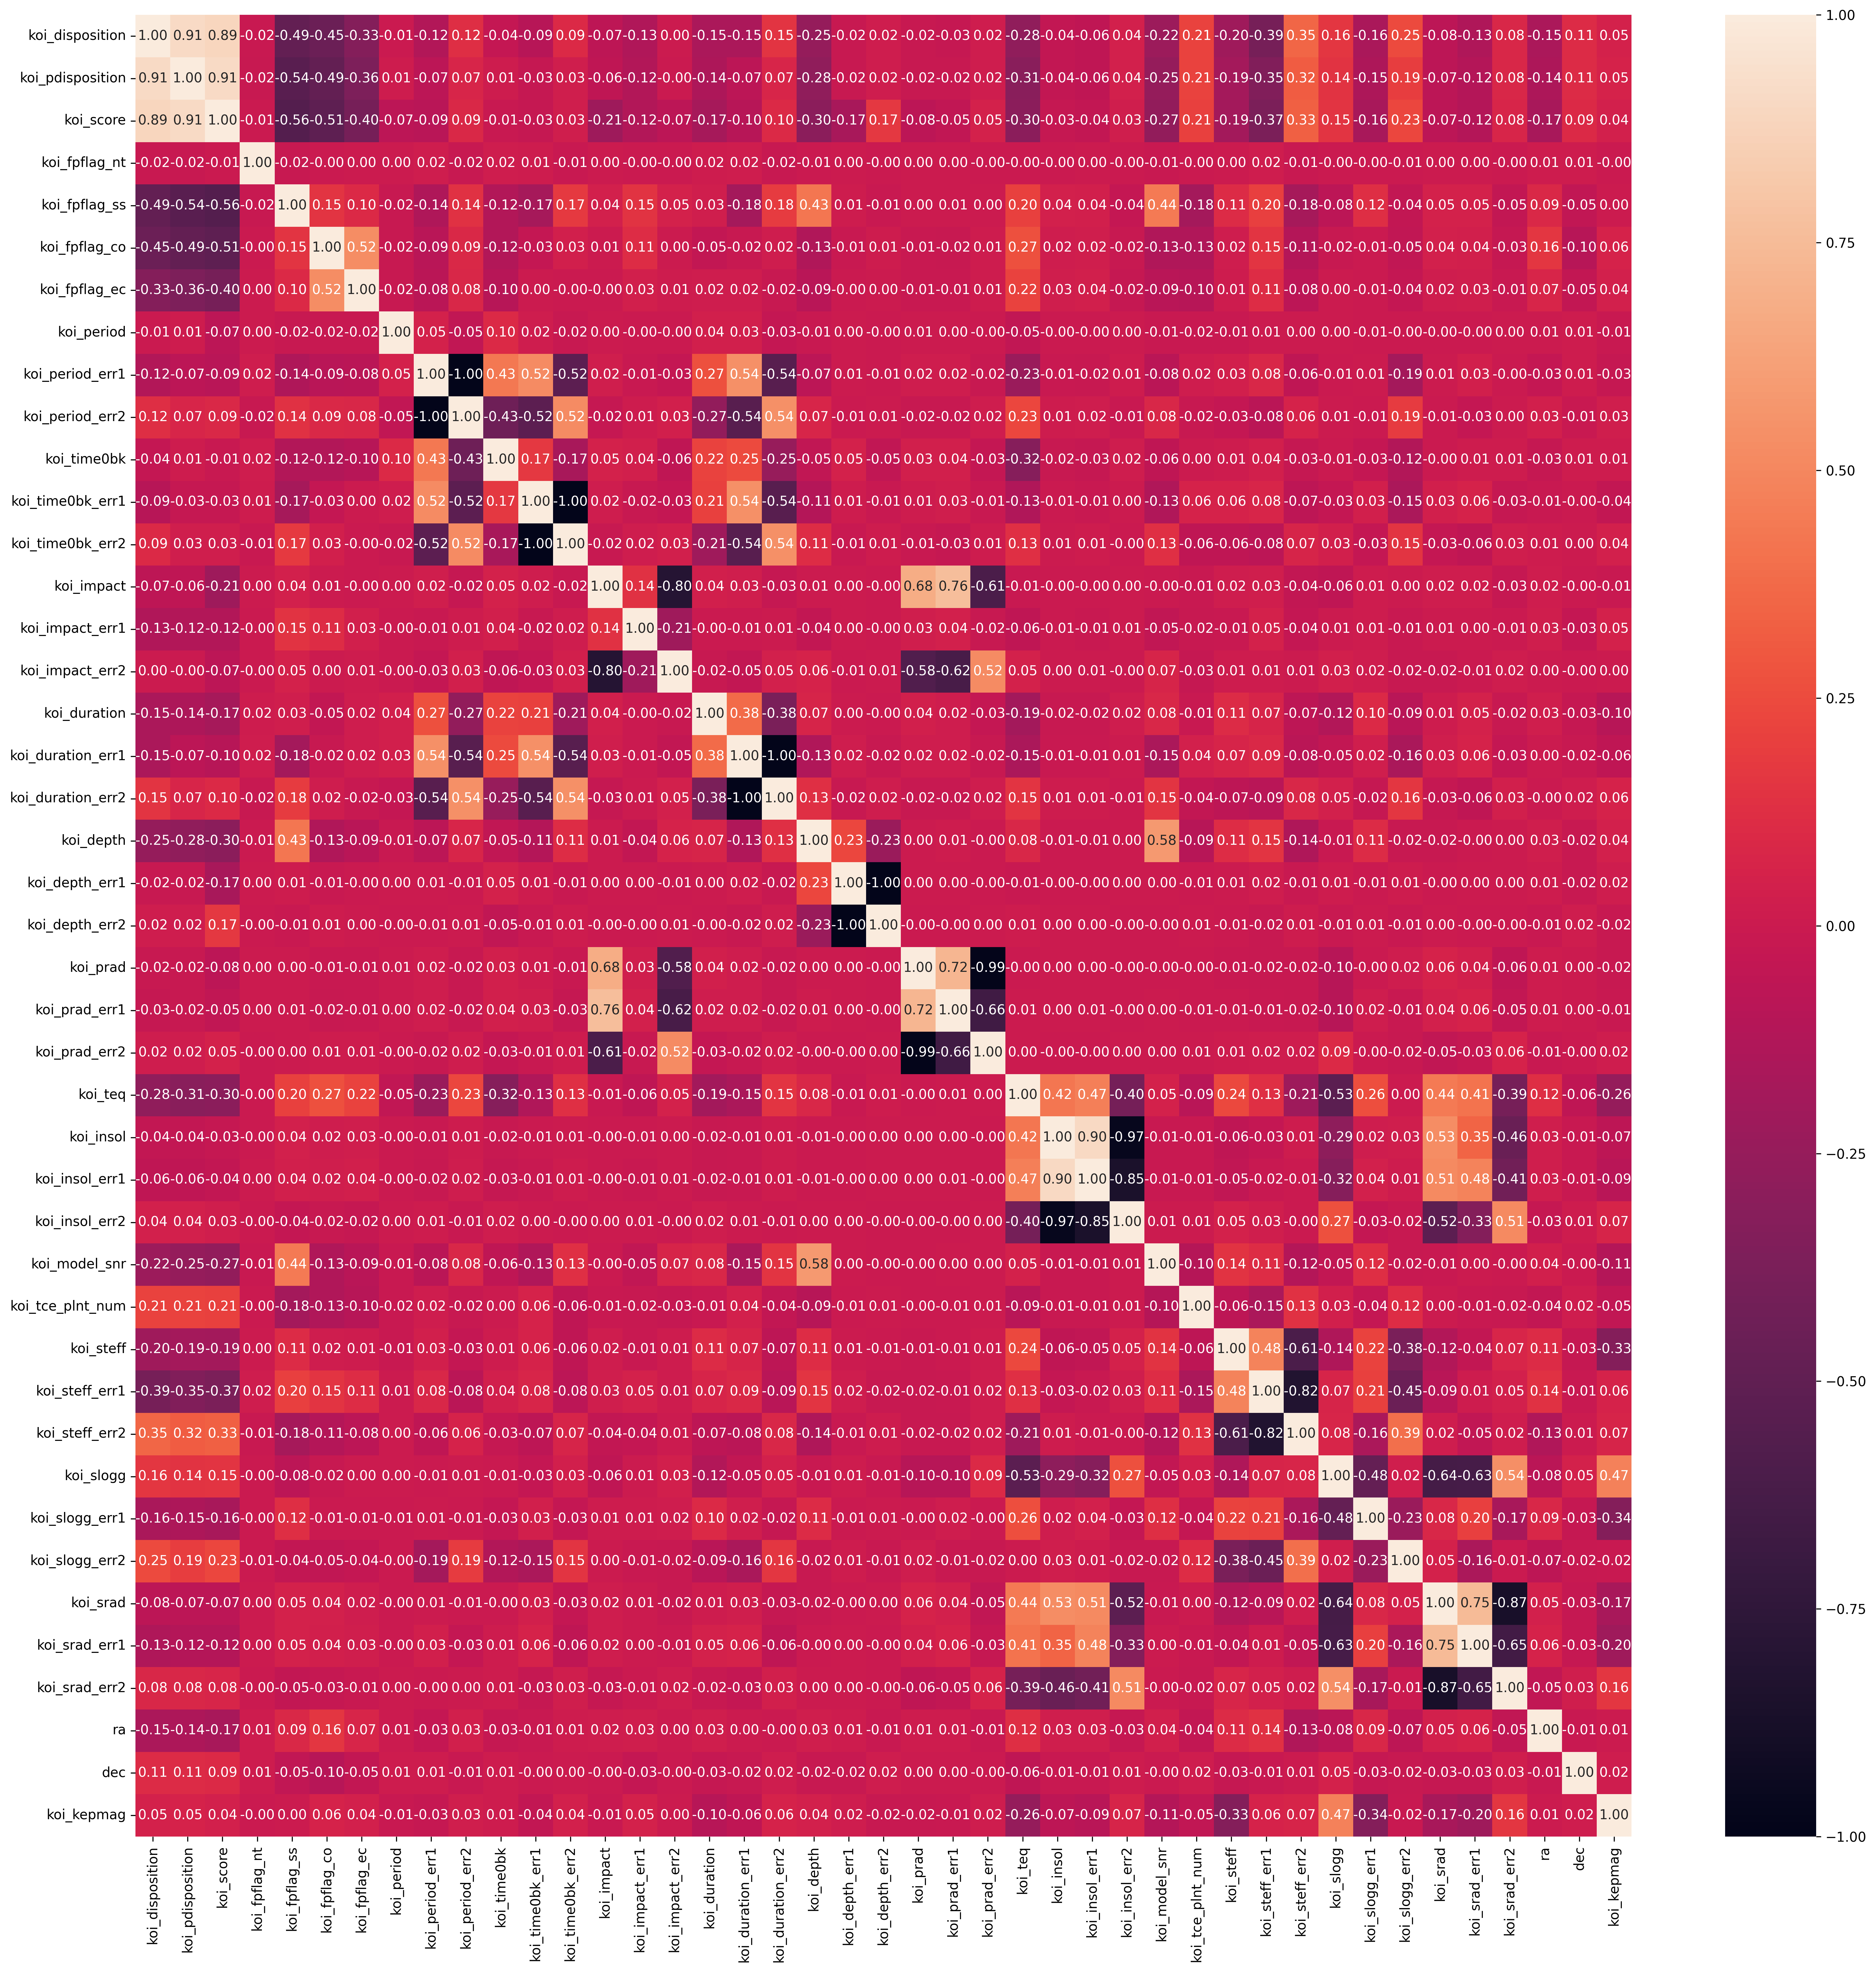

In [140]:
fig = plt.figure(figsize=(25, 25), dpi=300)
sns.heatmap(data.corr(), annot=True, fmt='.2f')


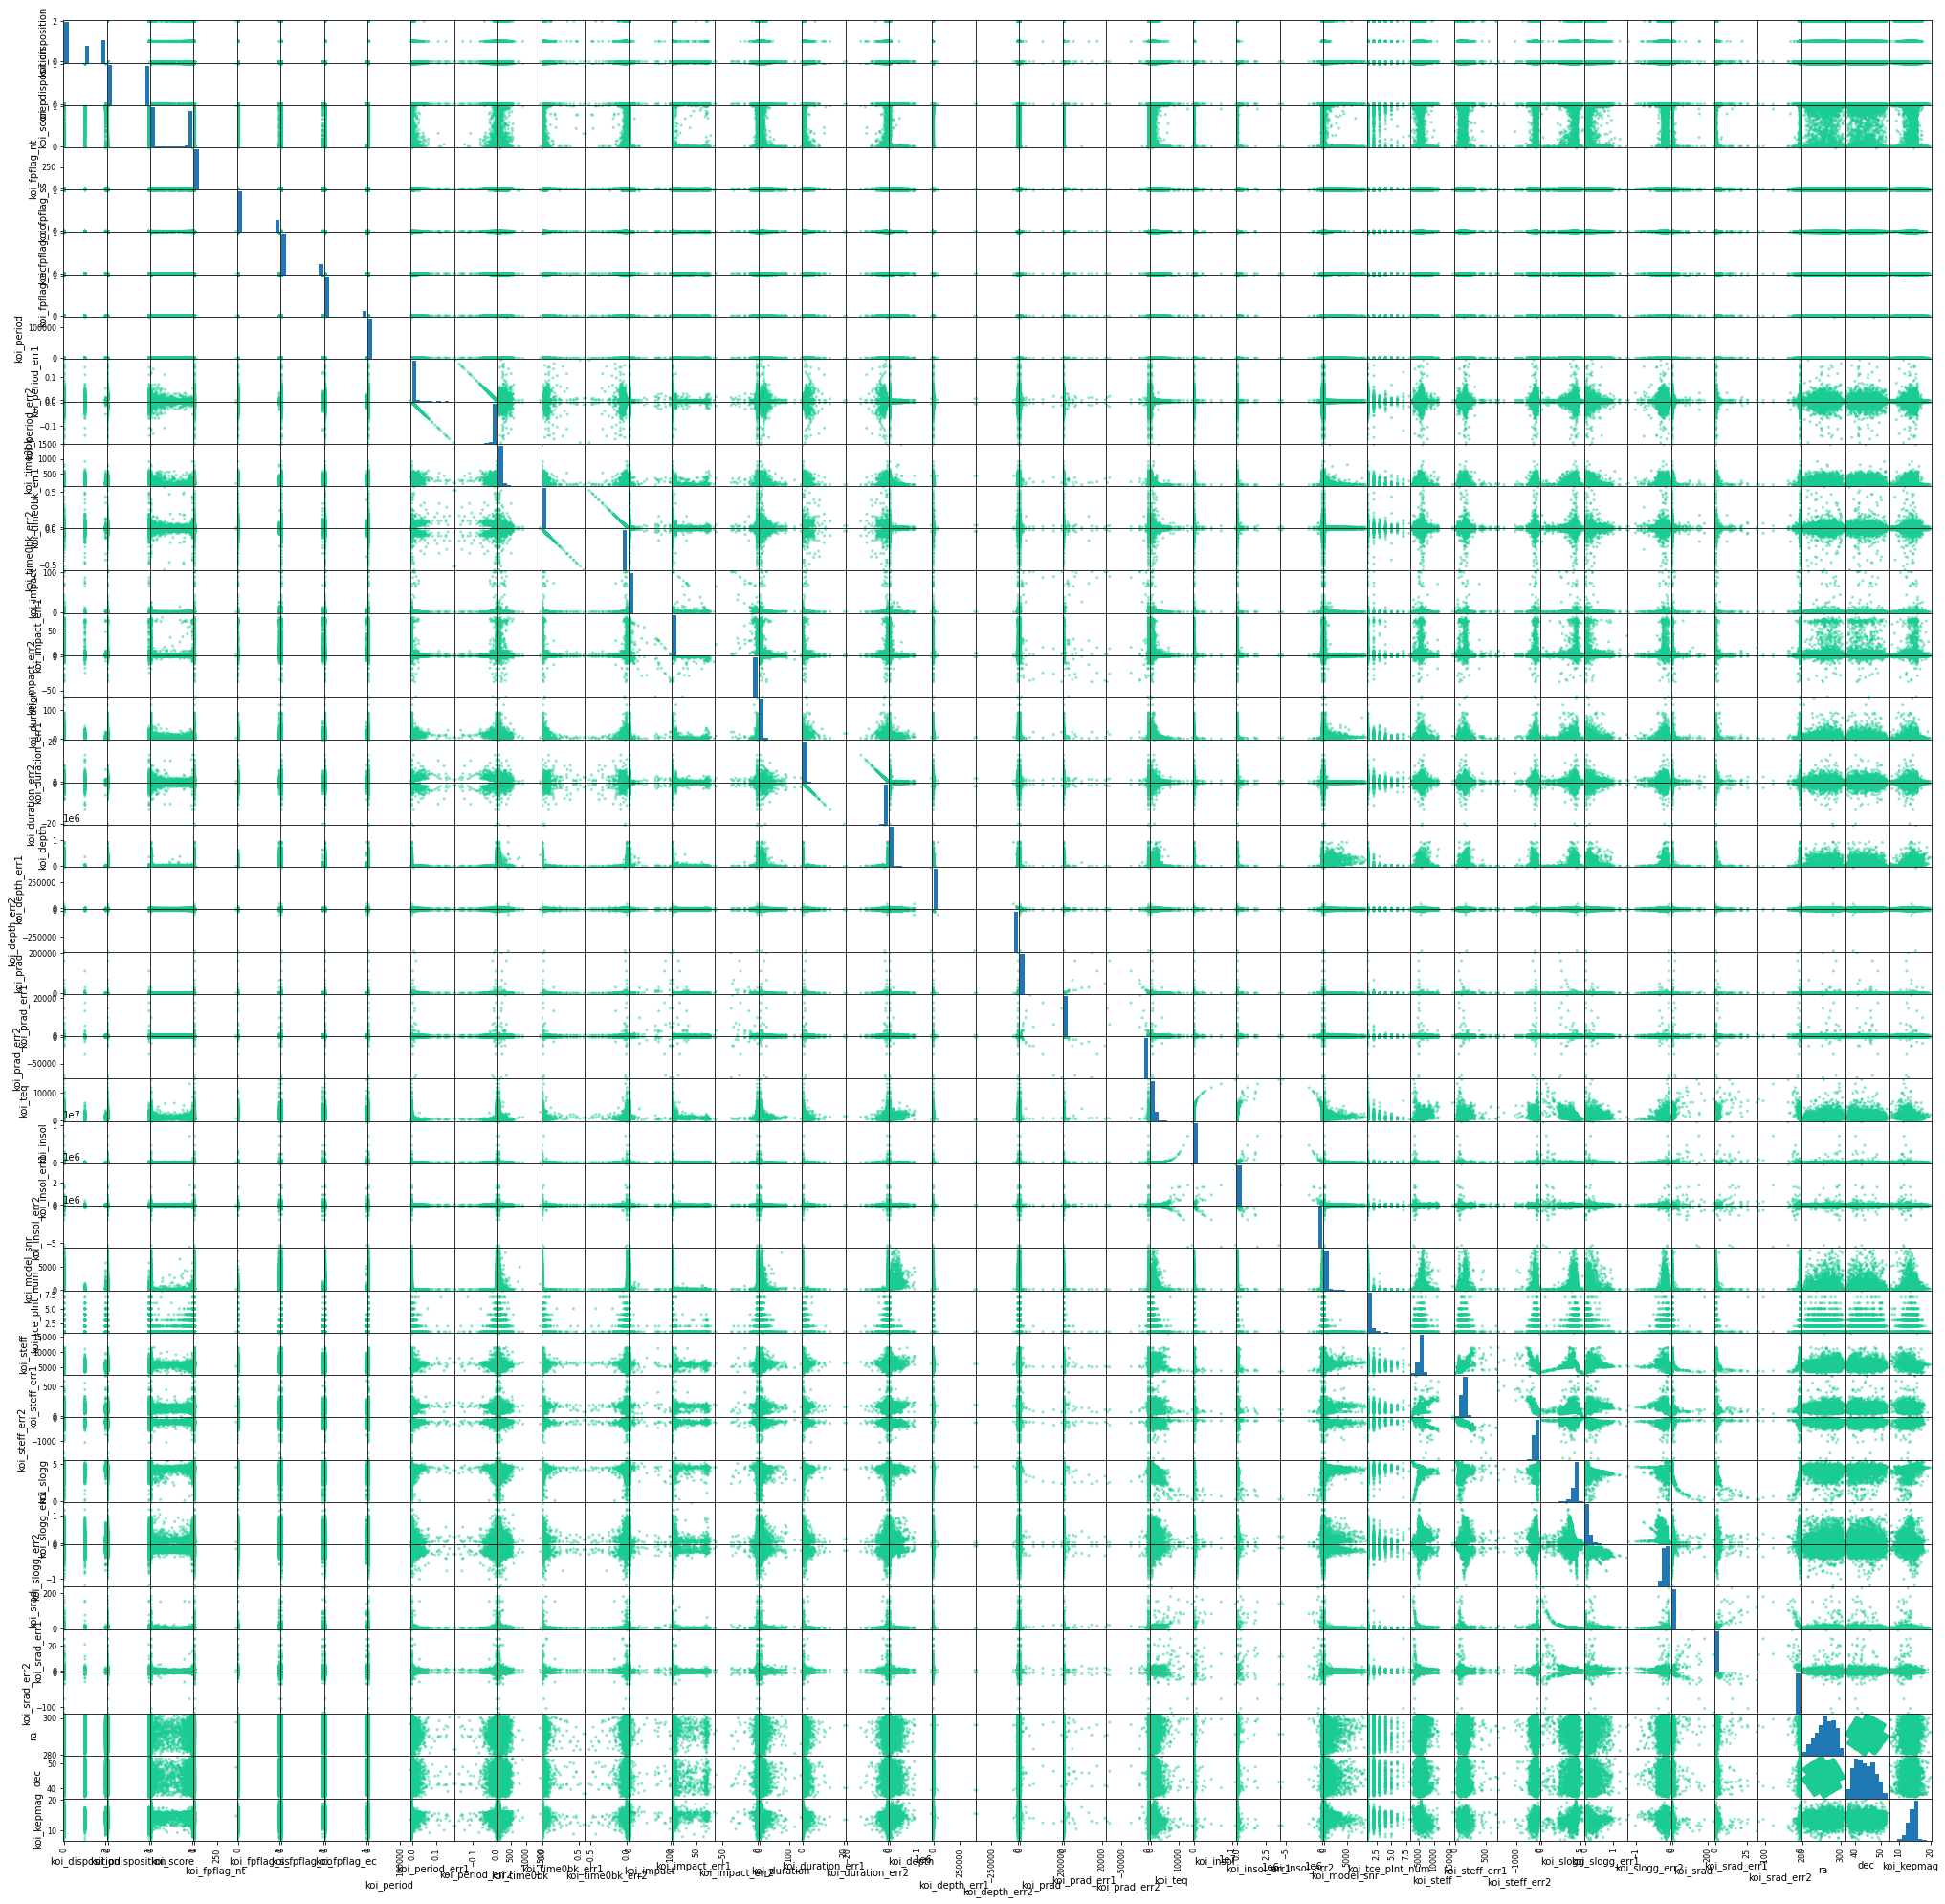

In [141]:
pd.plotting.scatter_matrix(data, figsize=(35, 35), c = "#1ACC94")
#plt.figure(figsize=(9, 9))
plt.show()


In [5]:
# MinMax nur um den Boxplot darzustellen. Danach müssen Trainings- und Testdaten individuell MinMax-skaliert werden.

minmax = MinMaxScaler()
for column in data:

    if column == 'koi_disposition':
        pass
    else:
        data[column] = minmax.fit_transform(
            data[column].to_numpy().reshape(-1, 1))


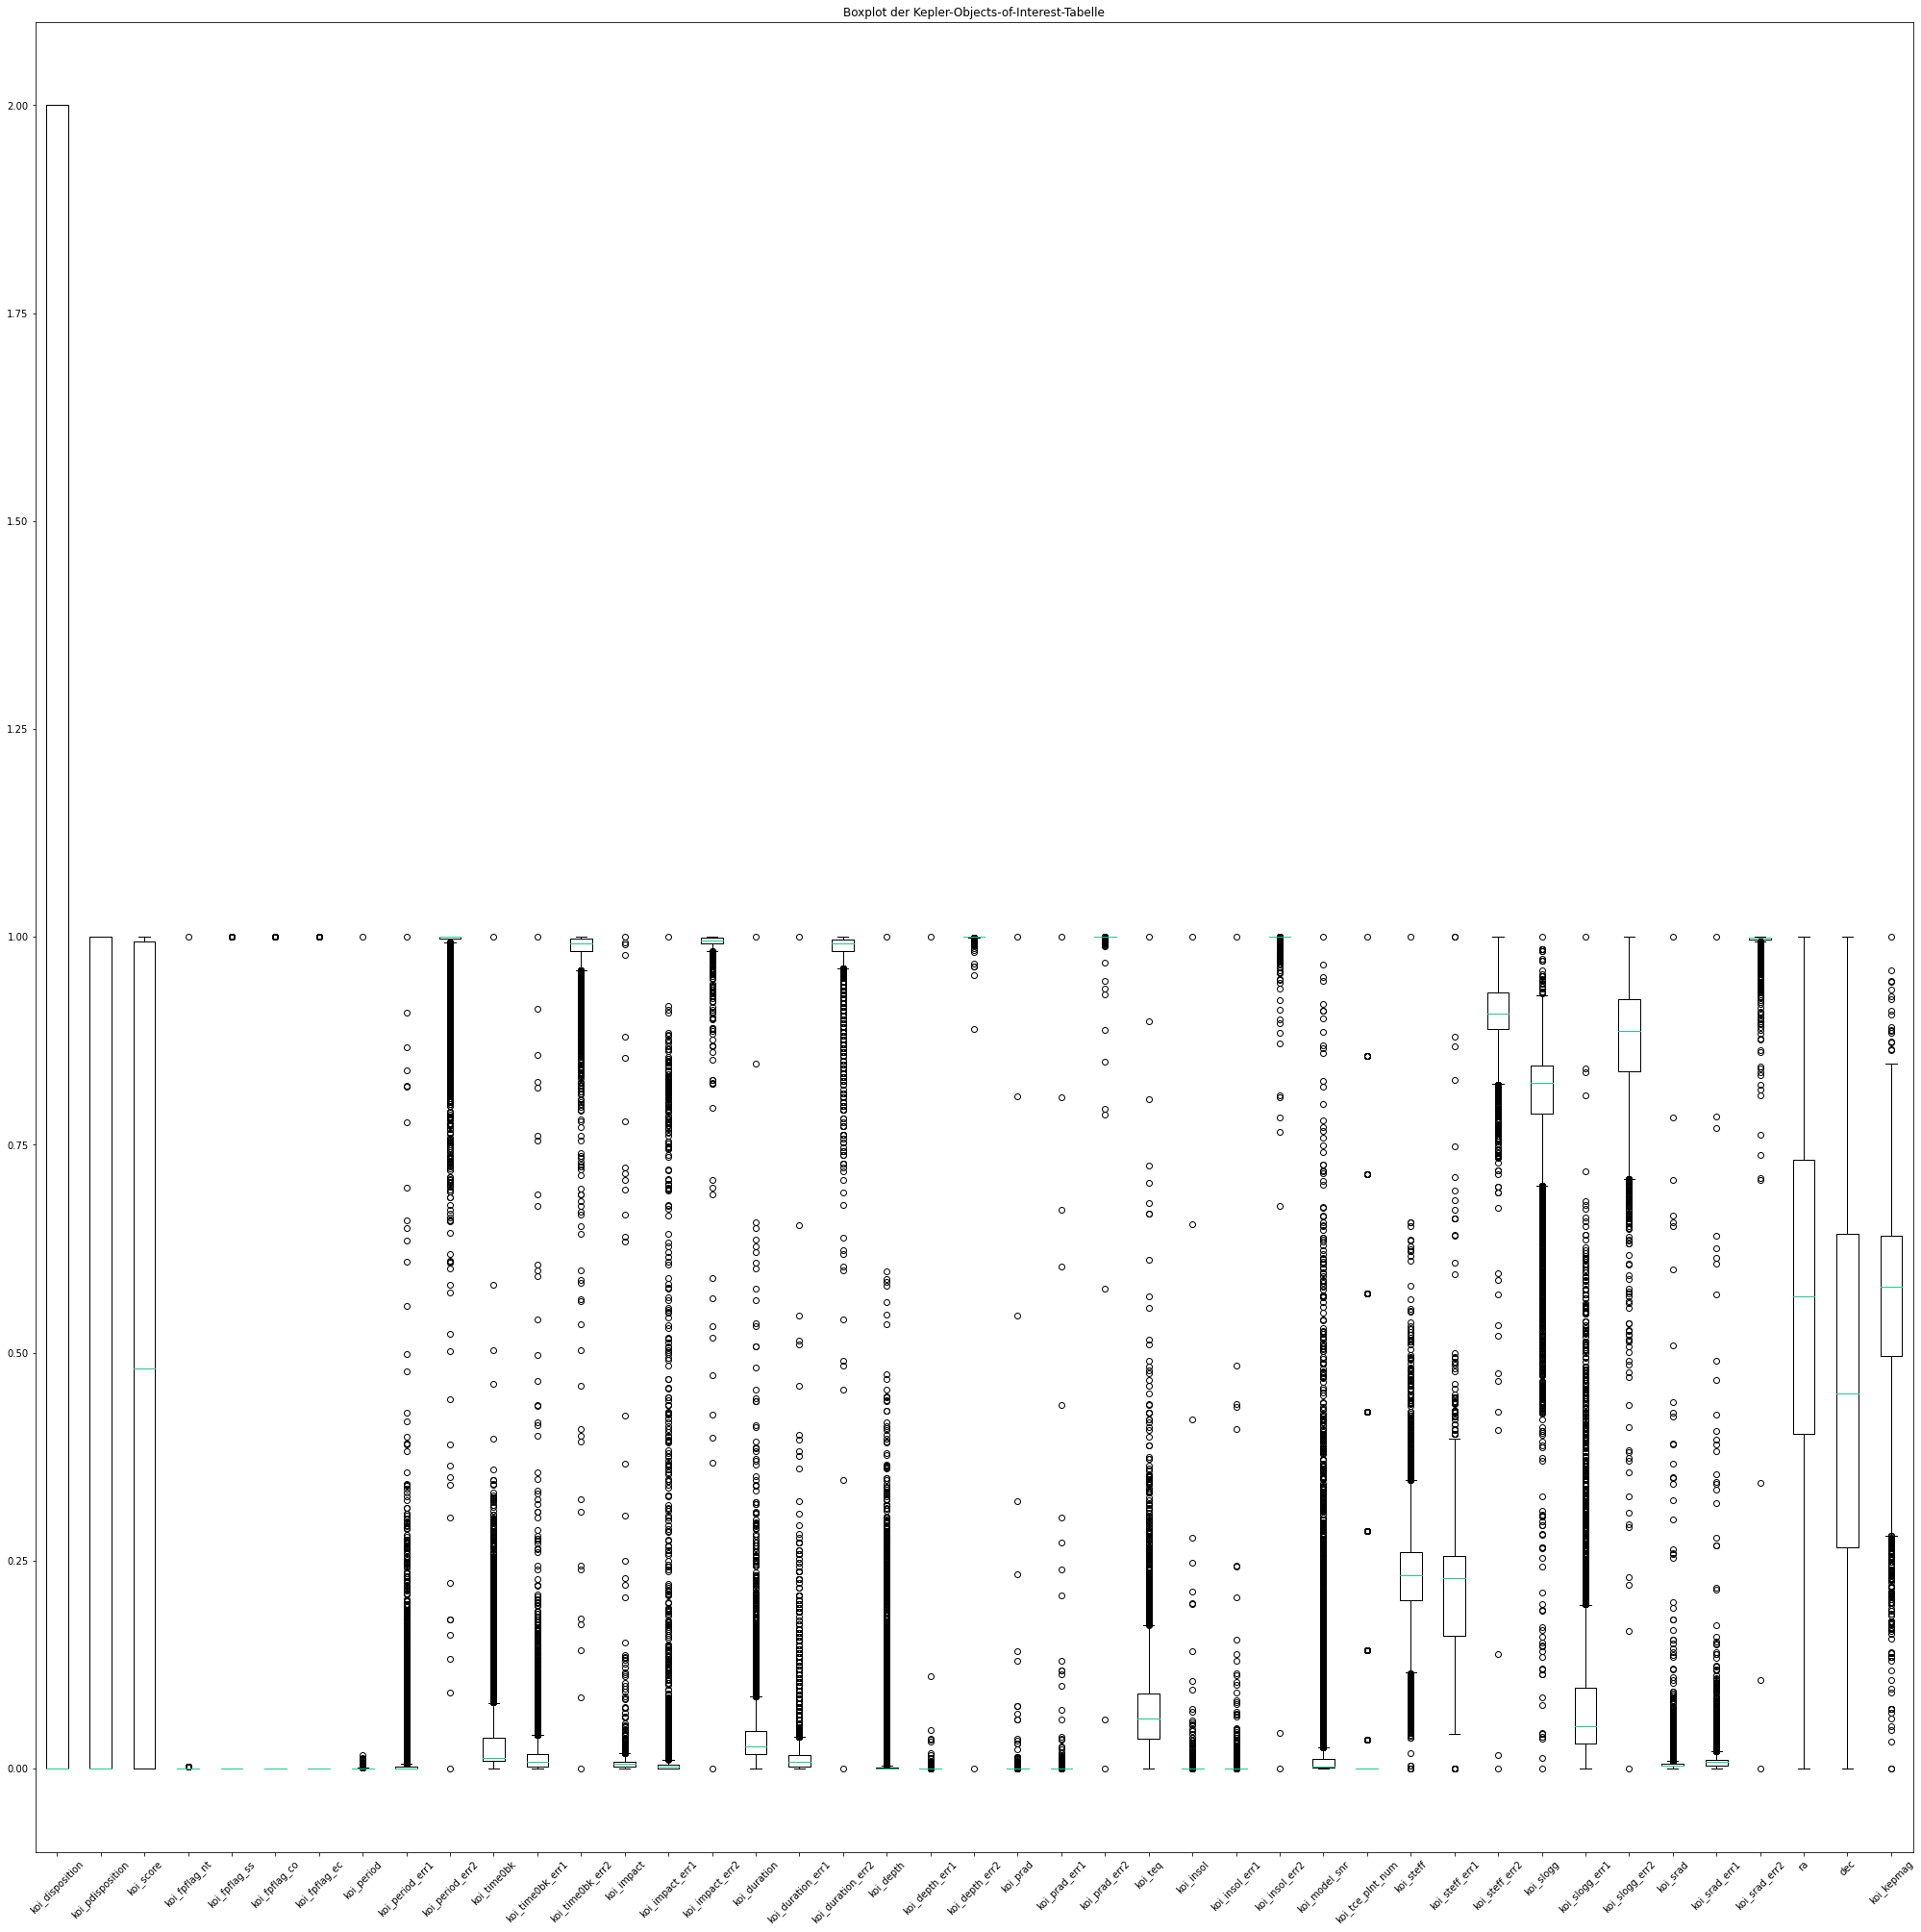

In [171]:
fig = plt.figure(figsize=(35, 35))
plt.title("Boxplot der Kepler-Objects-of-Interest-Tabelle")
plt.boxplot(data, labels=data.columns, medianprops=dict(color="#1ACC94"))
plt.xticks(rotation=45)
plt.show()

In [252]:
# *_err*-Features zu entfernen verringert die Akkuranz
x = data.drop(['koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_ss', 'koi_fpflag_co',
               'koi_fpflag_ec', 'koi_fpflag_nt'], axis=1)
y = data["koi_disposition"].to_numpy().reshape(-1, 1)
type(x), type(y)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25)#, random_state=45)

In [254]:
x_train, x_test, y_train, y_test = train_test_split(x, y)  # , test_size=0.25)

minmax = MinMaxScaler()
for column in x_train:

    if column == 'koi_disposition':
        pass
    else:
        x_train[column] = minmax.fit_transform(x_train[column].to_numpy().reshape(-1, 1))

        x_test[column] = minmax.fit_transform(x_test[column].to_numpy().reshape(-1, 1))

x_train.head()


koi_period  koi_period_err1  koi_period_err2  koi_time0bk  \
5252    0.000071         0.000121         0.999879     0.008828   
70      0.000335         0.000557         0.999443     0.023239   
3855    0.000010         0.012451         0.987549     0.008487   
3074    0.000027         0.000022         0.999978     0.037754   
987     0.000712         0.004024         0.995976     0.039026   

      koi_time0bk_err1  koi_time0bk_err2  koi_impact  koi_impact_err1  \
5252          0.003087          0.996913    0.012073         0.128362   
70            0.003351          0.996649    0.008452         0.000497   
3855          0.017433          0.982567    0.004662         0.024982   
3074          0.001407          0.998593    0.006389         0.002957   
987           0.009520          0.990480    0.000188         0.005379   

      koi_impact_err2  koi_duration  ...  koi_steff_err2  koi_slogg  \
5252         0.997370      0.045162  ...        0.922247   0.684973   
70           0.990138      0.048741  ...        0.933598   0.819823   
3855         0.994394      0.010944  ...        0.908627   0.437465   
3074         0.992667      0.014024  ...        0.913734   0.851420   
987          0.999680      0.039382  ...        0.948354   0.872108   

      koi_slogg_err1  koi_slogg_err2  koi_srad  koi_srad_err1  koi_srad_err2  \
5252        0.576087        0.765534  0.011118       0.038628       0.984269   
70          0.061141        0.908865  0.003930       0.006045       0.999113   
3855        0.020380        0.975145  0.063399       0.120397       0.967719   
3074        0.025815        0.874068  0.003033       0.007145       0.999371   
987         0.014946        0.979287  0.002058       0.001060       0.999742   

            ra       dec  koi_kepmag  
5252  0.294091  0.446650    0.547119  
70    0.960814  0.492439    0.472224  
3855  0.325702  0.147309    0.501958  
3074  0.525897  0.581936    0.634402  
987   0.629217  0.714632    0.709216  

[5 rows x 36 columns]

In [295]:
import warnings
warnings.filterwarnings('ignore')
br_test = len(np.where(y_test == 0)[0])/len(y_test)
br_data = len(data.loc[data['koi_disposition'] == 0]) / len(data['koi_disposition'])
print(f"Basisrate der Testdaten: {br_test:.04}")
print(f"Basisrate des Gesamten Datensatzes: {br_data:.04}")

methods = [("logregr", LogisticRegression()), ("knn", KNeighborsClassifier()), ("bag",
BaggingClassifier()), ("svm", SVC()), ("ada", AdaBoostClassifier()), ("tree",
DecisionTreeClassifier()), ("forest", RandomForestClassifier())]

for method in methods:
    model = method[1].fit(x_train, y_train)
    model_predict = np.round(model.predict(x_test))
    model_accuracy = accuracy_score(model_predict, y_test)
    print(f"Genauigkeit von {method[0]}: {model_accuracy:.04}")


vote_estimators = methods[4:] # Nur ohne logreg, knn und bag kann feature importance von vote bestimmt
                              # werden, da erstere keinen accuracy score haben.
voting_class = VotingClassifier(estimators=vote_estimators, weights=[1, 1, 2])
voting_class.fit(x_train, y_train)
predict = np.round(voting_class.predict(x_test))
vot_accuracy = accuracy_score(predict, y_test)
print(f"Genauigkeit vom Voting Classifier: {vot_accuracy:.04}")



Basisrate der Testdaten: 0.5161
Basisrate des Gesamten Datensatzes: 0.506
Genauigkeit von logregr: 0.652
Genauigkeit von knn: 0.6374
Genauigkeit von bag: 0.5784
Genauigkeit von svm: 0.6608
Genauigkeit von ada: 0.6131
Genauigkeit von tree: 0.522
Genauigkeit von forest: 0.6587
Genauigkeit vom Voting Classifier: 0.6311


In [ ]:
grid_points_degree = np.range(1, 8)
grid_points_interaction_only = (False, True)
grid_points_include_bias = (False, True)
grid_points_penalty = ("l1", "l2", "elasticnet", "none")
grid_points_dual = (False, True)
grid_points_C = np.arange(1, 7)
grid_points_fit_intercept = (False, True)
grid_points_solver = ("newton-cg", "lbfgs", "liblinear", "sag", "saga")
tol = 1e-5

for degree in grid_points_degree:
    for interaction_only in grid_points_interaction_only:
        for include_bias in grid_points_include_bias:
            for penalty in grid_points_penalty:
                for dual in grid_points_dual:
                    for C in grid_points_C:
                        for fit_intercept in grid_points_fit_intercept:
                            for solver in grid_points_solver:
                                poly = PolynomialFeatures(degree=degree,
                                    interaction_only=interaction_only, include_bias = include_bias)
                                x_poly = poly.fit_transform(x_train.reshape(-1, 1))
                                model = LinearRegression(penalty=penalty, dual=dual, C=C,
                                    fit_intercept=fit_intercept, solver=solver)
                                model_fit = model.fit(x_poly, y_train)
                                prediction = model.predict(poly.transform(studying.reshape(-1, 1)))

                            

In [ ]:
grid_points_n_neighbors = np.range(5, 66, 2)
grid_points_weights = ("uniform", "distance")
grid_points_algorithm = ("auto", "ball_tree", "kd_tree", "brute")
grid_points_p = (1, 2)

max_z = -np.inf
best_point = (5, "uniform", "auto", 1)

for n_neighbors in grid_points_n_neighbors:
    for weights in grid_points_weights:
        for algorithm in grid_points_algorithm:
            for p in grid_points_p:
                knn = KNeighborsClassifier(
                    n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, p=p)
                knn_model_fit = knn.fit(x_train, y_train)
                knn_model_predict = kn.predict(x_test)
                z = accuracy_score(knn_model_predict, y_test)
                print(z, max_z, best_point, (n_neighbors, weights, algorithm, p))
                if z > max_z:
                    max_z = z
                    best_point = (n_neighbors, weights, algorithm, p)

print(f"Bester Punkt mit z={max_z:.04f} gefunden bei {best_point}")


In [340]:
grid_points_C = np.arange(0.2, 8, 0.2)
#grid_points_kernel = ("linear", "poly", "rbf", "sigmoid")
grid_points_kernel = ("poly", "sigmoid")
grid_points_degree = np.arange(1, 8)
grid_points_gamma = ("scale", "auto")
max_z = -np.inf
#best_point = (1, "linear", 1, "scale")
best_point = (0.2, "poly", 1, "scale")

for C in grid_points_C:
    for kernel in grid_points_kernel:
        for degree in grid_points_degree:
            for gamma in grid_points_gamma:
                svm = SVC(C=C, kernel="poly", degree=degree,
                            gamma="scale", random_state=1)
                svm_model_fit = svm.fit(x_train, y_train)
                svm_model_predict = svm.predict(x_test)
                z = accuracy_score(svm_model_predict, y_test)
                print(z, max_z, best_point, (C, kernel, degree, gamma))
                if z > max_z:
                    max_z = z
                    best_point = (C, kernel, degree, gamma)

print(f"Bester Punkt mit z={max_z:.04f} gefunden bei {best_point}")
#Bester Punkt bei  0.7001254705144291 (1, 'poly', 6, 'scale')
#Bester Punkt bei 0.7022166457549143 (2.4, 'sigmoid', 5, 'auto')


0.5591802593057298 -inf (1, 'linear', 1, 'scale') (0.2, 'poly', 1, 'scale')
0.5591802593057298 0.5591802593057298 (0.2, 'poly', 1, 'scale') (0.2, 'poly', 1, 'auto')
0.6256796319531577 0.5591802593057298 (0.2, 'poly', 1, 'scale') (0.2, 'poly', 2, 'scale')
0.6256796319531577 0.6256796319531577 (0.2, 'poly', 2, 'scale') (0.2, 'poly', 2, 'auto')
0.6641572563780845 0.6256796319531577 (0.2, 'poly', 2, 'scale') (0.2, 'poly', 3, 'scale')
0.6641572563780845 0.6641572563780845 (0.2, 'poly', 3, 'scale') (0.2, 'poly', 3, 'auto')
0.6817231283981597 0.6641572563780845 (0.2, 'poly', 3, 'scale') (0.2, 'poly', 4, 'scale')
0.6817231283981597 0.6817231283981597 (0.2, 'poly', 4, 'scale') (0.2, 'poly', 4, 'auto')
0.6884148891677122 0.6817231283981597 (0.2, 'poly', 4, 'scale') (0.2, 'poly', 5, 'scale')
0.6884148891677122 0.6884148891677122 (0.2, 'poly', 5, 'scale') (0.2, 'poly', 5, 'auto')
0.6976160602258469 0.6884148891677122 (0.2, 'poly', 5, 'scale') (0.2, 'poly', 6, 'scale')
0.6976160602258469 0.69761606

In [ ]:
#grid_points_n_estimators = np.arange(1, 502, 50)
#grid_points_max_depth = np.arange(1, 11)
#grid_points_min_samples_split = np.arange(2, 33, 3)
#grid_points_max_features = (None, "auto")
#best_point = (1, 1, 2, None)

# grid_points_n_estimators = np.arange(30, 71, 5)
# grid_points_max_depth = np.arange(7, 10)
# grid_points_min_samples_split = np.arange(2, 30, 3)
# grid_points_max_features = (None, "auto")


grid_points_n_estimators = np.arange(35, 60)
grid_points_max_depth = np.arange(7, 11)
grid_points_min_samples_split = (2, 33, 3)
grid_points_max_features =  "auto"
max_z = -np.inf
best_point = (1, 1, 2, None)
for n_estimators in grid_points_n_estimators:
    for max_depth in grid_points_max_depth:
        for min_samples_split in grid_points_min_samples_split:
            #for max_features in grid_points_max_features:
            rf = RandomForestClassifier(n_estimators = n_estimators, criterion = "entropy", max_depth = max_depth,
                                        min_samples_split = min_samples_split, max_features = "auto", random_state = 1)
            rf_fit = rf.fit(x_train, y_train)
            z = accuracy_score(rf.predict(x_test), y_test)
            print(z, max_z, best_point, (n_estimators,
                    max_depth, min_samples_split)) #, max_features))
            if z > max_z:
                max_z = z
                best_point = (n_estimators, max_depth, min_samples_split)#, max_features)

print(f"Bester Punkt mit z={max_z:.04f} gefunden bei {best_point}")
#Bester Punkt mit z= 0.7168548724383104 gefunden bei (44, 9, 2)


# Maxima gefunden bei
# 51,   9,      2, 'auto'. Akkuranz: 0.7114178168130489
# (51	7		26	None) Akkuranz: 0, 7080719364
# (51	9		23	'auto') Akkuranz: 0,7022166458
#(51	7		5	None) Akkuranz: 0,7009619406

#(101	9		2	'auto') Akkuranz: 0,6992890004

#(51	7		11	None) Akkuranz: 0,6988707654
#(51	7		29	'auto') Akkuranz: 0,6980342953
#(51	9		11	None) Akkuranz: 0,6980342953

#(301	9		2	'auto') Akkuranz: 0,6976160602

#(451	9		2	None) Akkuranz: 0,6976160602

#(51	7		17	'auto') Akkuranz: 0,6971978252

#(401	9		2	None) Akkuranz: 0,6971978252


# Bester	Punkt	mit	z=0.7156	gefunden	bei	(45,	9	2	'auto')
# (45,	9	2	'auto') 0.7156001672940192
# (35,	9	2	'auto') 0.7147636971978252
# (55,	9	2	'auto') 0.7139272271016311
# (35,	7	26	'auto') 0.7135089920535341
# (50,	9	2	'auto') 0.71267252195734
# (30,	9	2	'auto') 0.711836051861146
# (45,	7	26	'auto') 0.7114178168130489
# (60,	9	2	'auto') 0.7109995817649519
# (30,	7	26	'auto') 0.7101631116687579


0.6925972396486826 -inf (1, 1, 2, None) (30, 7, 2)
0.6942701798410706 0.6925972396486826 (30, 7, 2) (30, 7, 30)
0.6892513592639063 0.6942701798410706 (30, 7, 30) (30, 7, 3)
0.6813048933500627 0.6942701798410706 (30, 7, 30) (30, 8, 2)
0.6767043078209954 0.6942701798410706 (30, 7, 30) (30, 8, 30)
0.684650773734839 0.6942701798410706 (30, 7, 30) (30, 8, 3)
0.711836051861146 0.6942701798410706 (30, 7, 30) (30, 9, 2)
0.6879966541196152 0.711836051861146 (30, 9, 2) (30, 9, 30)
0.6884148891677122 0.711836051861146 (30, 9, 2) (30, 9, 3)
0.6930154746967796 0.711836051861146 (30, 9, 2) (32, 7, 2)
0.6946884148891677 0.711836051861146 (30, 9, 2) (32, 7, 30)
0.6930154746967796 0.711836051861146 (30, 9, 2) (32, 7, 3)
0.6833960685905479 0.711836051861146 (30, 9, 2) (32, 8, 2)
0.6775407779171895 0.711836051861146 (30, 9, 2) (32, 8, 30)
0.6825595984943539 0.711836051861146 (30, 9, 2) (32, 8, 3)
0.7143454621497282 0.711836051861146 (30, 9, 2) (32, 9, 2)
0.6884148891677122 0.7143454621497282 (32, 9, 2) (

In [303]:
# Optimisiertes Modell

best_point = (n_estimators, max_depth, min_samples_split)
rf_opt = RandomForestClassifier(n_estimators=best_point[0], criterion="entropy", max_depth=best_point[1],
                                min_samples_split=best_point[2], random_state=1)
rf_opt.fit(x_train, y_train)
predict = rf_opt.predict(x_test)

cm = confusion_matrix(predict, y_test)
tn, fp, fn, tp = cm.ravel()

print(f"Accuracy: {accuracy_score(predict, y_test)}")
print(f"Confusion matrix: \n{cm}")


NameError: name 'n_estimators' is not defined

In [294]:
x_train_logreg = x_train.drop(['koi_period', 'koi_period_err2', 'koi_time0bk_err2',
                               'koi_duration_err2', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err2', 'koi_slogg_err1',
                               'koi_slogg_err2', 'dec', 'koi_kepmag'], axis=1)
x_test_logreg = x_test.drop(['koi_period', 'koi_period_err2', 'koi_time0bk_err2',
                              'koi_duration_err2', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err2', 'koi_slogg_err1',
                              'koi_slogg_err2', 'dec', 'koi_kepmag'], axis=1)

model = LogisticRegression().fit(x_train_logreg, y_train)
model_predict = np.round(model.predict(x_test_logreg))
model_accuracy = accuracy_score(model_predict, y_test)
print(f"Genauigkeit von logregr: {model_accuracy:.04}")


Genauigkeit von logregr: 0.6014


In [300]:
# Triviale Hypothese

predict = np.zeros(len(y_test))

cm = confusion_matrix(y_test, predict)
#tn, fp, fn, tp = cm.ravel()

print("--------------------------------- \n TRIVIALE HYPOTHESE")
print(f"Accuracy: {accuracy_score(y_test, predict)}")
print(f"Confusion matrix: \n{cm}")
print(1234/(1234+496+661))
print(len(np.where(y_test == 0)[0])/len(y_test))


--------------------------------- 
 TRIVIALE HYPOTHESE
Accuracy: 0.5161020493517356
Confusion matrix: 
[[1234    0    0]
 [ 496    0    0]
 [ 661    0    0]]
0.5161020493517356
0.5161020493517356


In [302]:
#Diagonale: Richtige vorhersagen. Oben links: Anzahl der richtigen Vorhersagen des kleinsten Wertes.
#                                 Unten rechts: Anzahl der richtigen Vorhersagen des größten Wertes.
# 1. Zeile: False Positive. Links: Anzahl der richtigen Vorhersagen. Mitte: Anzahl der fälschlicherweise als 1
# vorhergesagten. Rechts: Anzahl der fälschlicherweise als 2 vorhergesagten.
# 2. Zeile: Candidate. Links: Anzahl der Anzahl der fälschlicherweise als 0 vorhergesagten. Rechts: Anzahl der
# fälschlicherweise als 2 vorhergesagten.
# 3. Zeile: Confirmed. Links: Wie in 2. Zeile. Mitte: Wie in 1. Zeile.
y_true = [0, 1, 1, 2, 2, 2] 
y_pred = [0, 1, 2, 2, 2, 2]
confusion_matrix(y_true, y_pred)


array([[1, 0, 0],
       [0, 1, 1],
       [0, 0, 3]], dtype=int64)

In [260]:
warnings.filterwarnings('ignore')


def rmse(y_pred, y):
    return np.sqrt(np.mean((y_pred-y)**2))


def train_evaluate_time(method):
    start_time = time.time()
    methods[method].fit(x_train, y_train)
    running_time = round(time.time() - start_time, 2)
    model_predict = methods[method].predict(x_test)
    model_rmse = rmse(model_predict, y_test)
    print(
        f"Genauigkeit von {method}: {model_rmse:.05}; running time: {running_time}")


methods = {"logregr": LogisticRegression(), "bag": BaggingClassifier(), "ada": AdaBoostClassifier(),  "tree": DecisionTreeClassifier(), "knn": KNeighborsClassifier(),
           "forest": RandomForestClassifier(), "svm": SVC()}

for method in methods:
    train_evaluate_time(method)


Genauigkeit von logregr: 1.208; running time: 0.33
Genauigkeit von bag: 1.1234; running time: 2.13
Genauigkeit von ada: 1.1075; running time: 1.3
Genauigkeit von tree: 1.152; running time: 0.3
Genauigkeit von knn: 1.1975; running time: 0.0
Genauigkeit von forest: 1.1775; running time: 3.79
Genauigkeit von svm: 1.2278; running time: 4.2


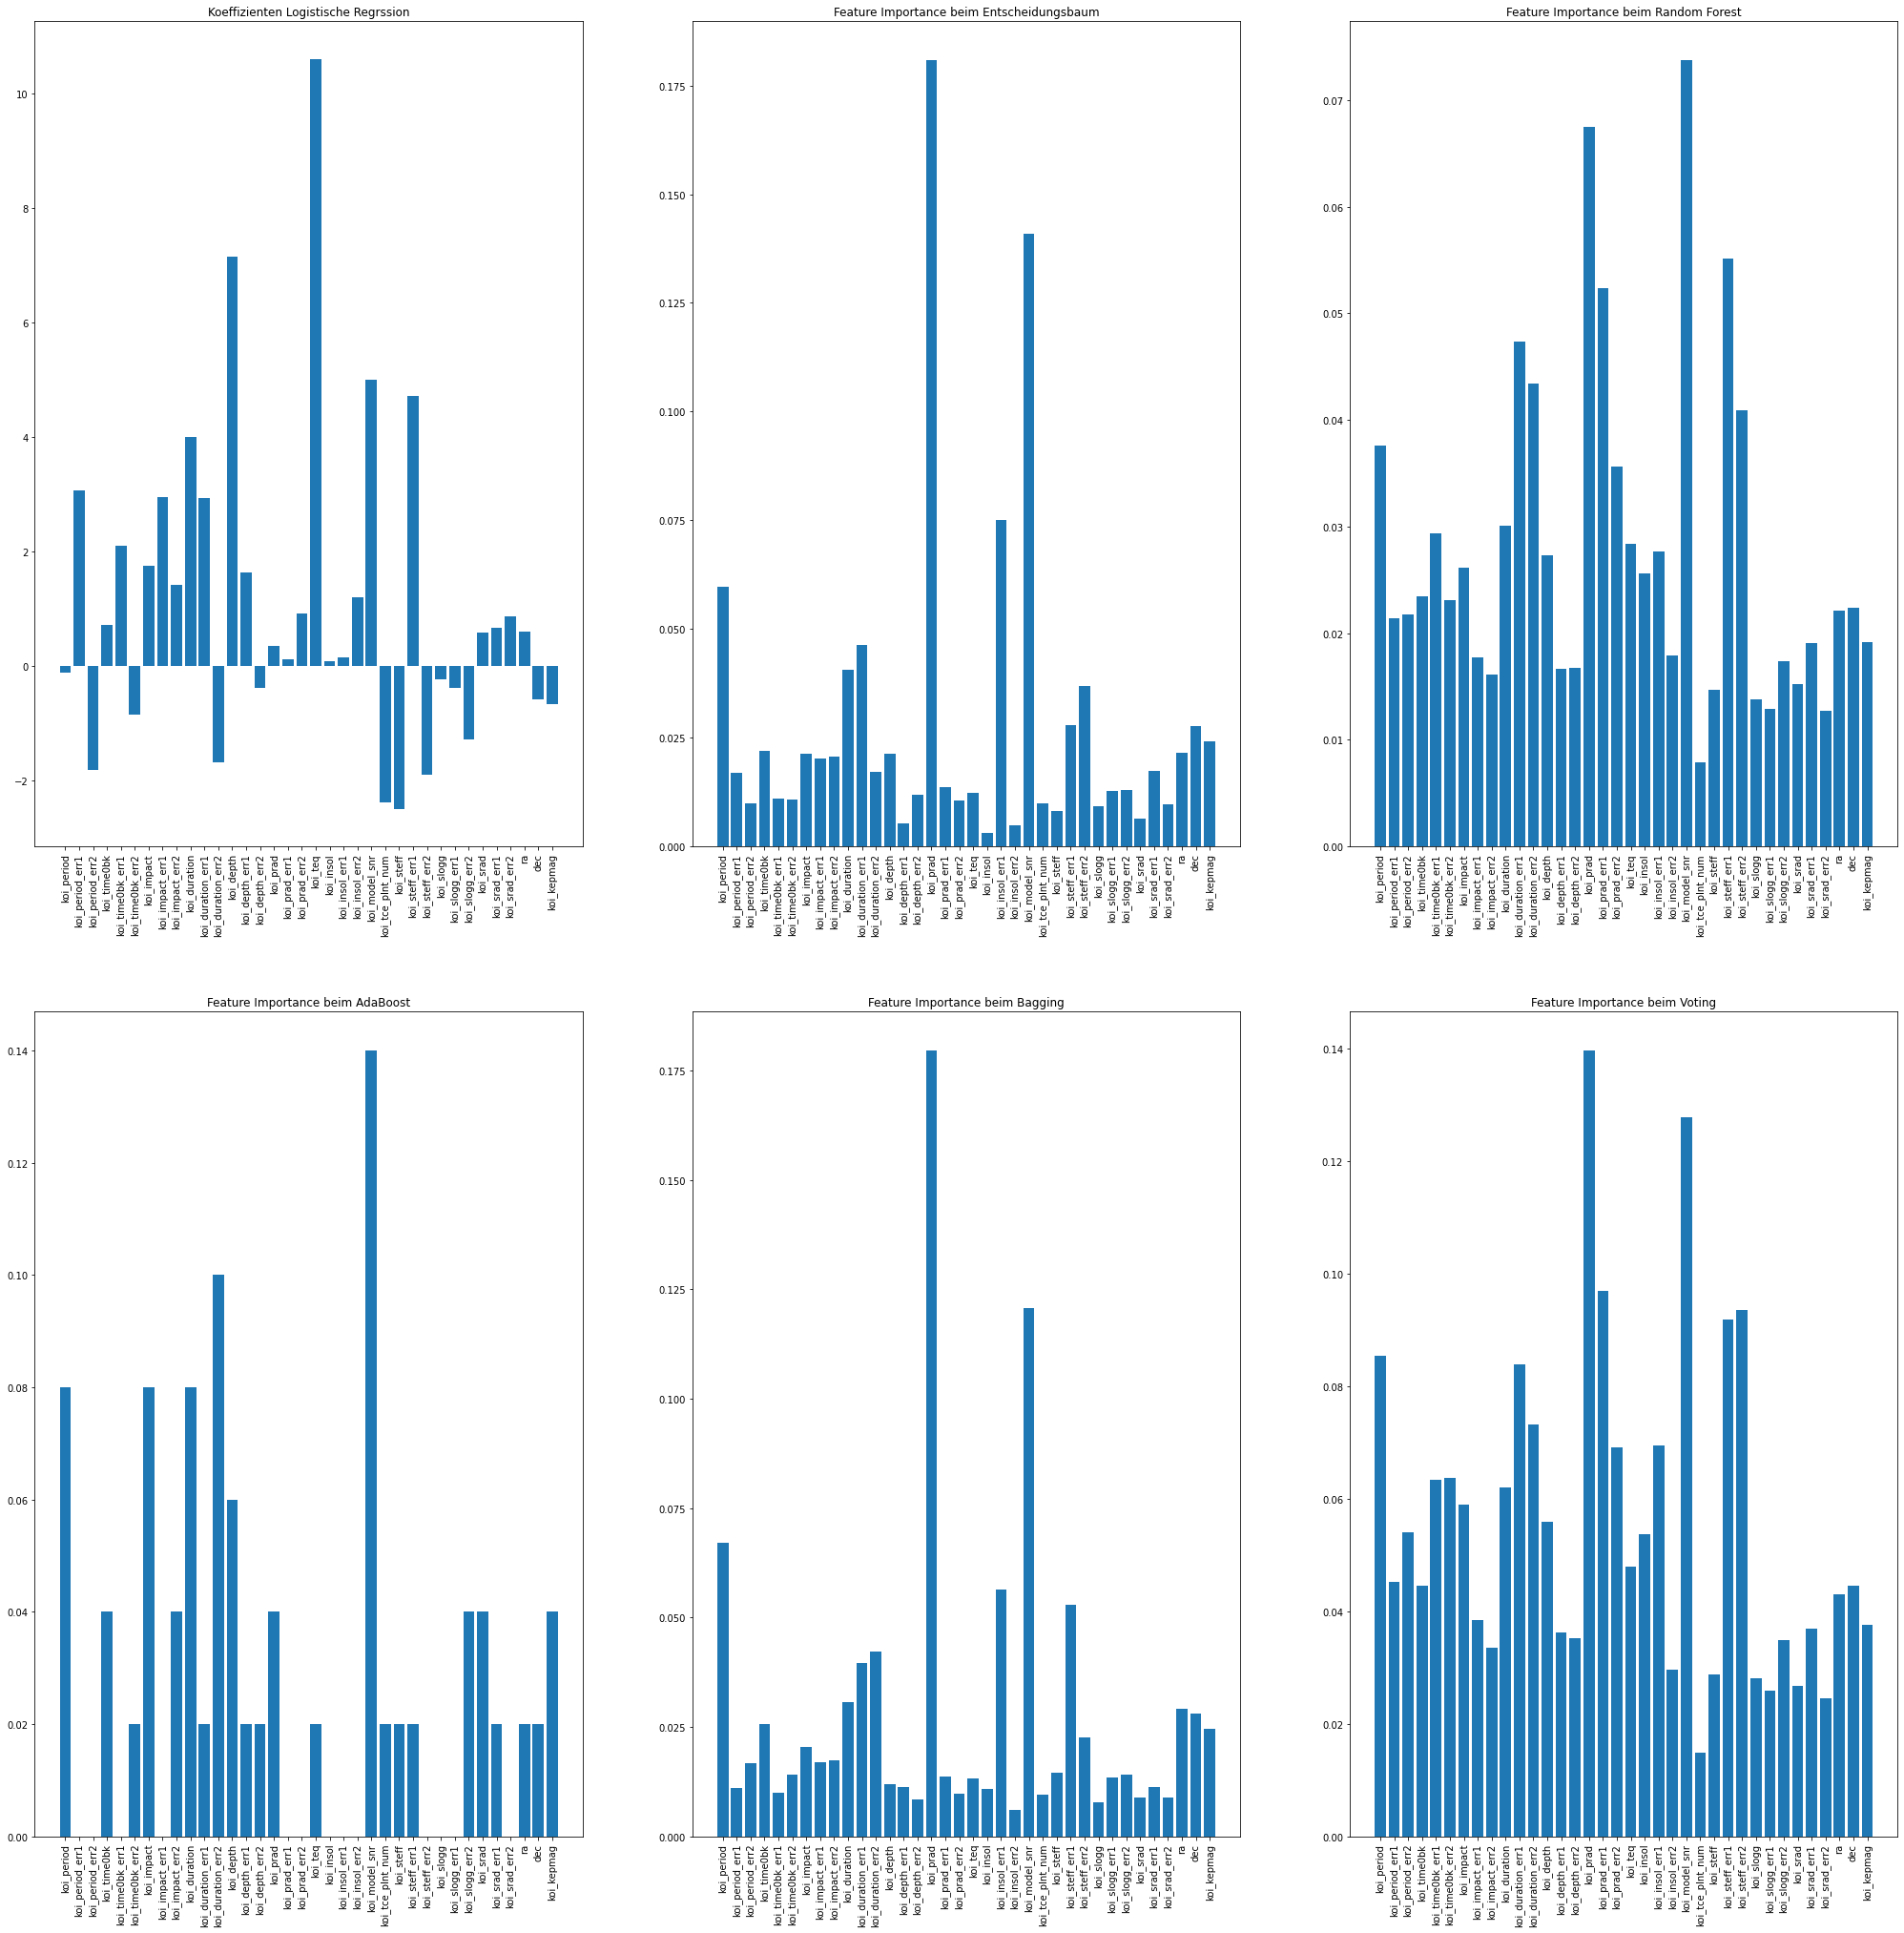

In [262]:
bag  = BaggingClassifier(DecisionTreeClassifier())
bag.fit(x_train, y_train)

bag_feature_importances = np.mean([tree.feature_importances_ for tree in bag.estimators_], axis=0)

def voting_feature_importance(voting_class, weights):
    """ Funktion, welche feature importance des Voting Classifier berechnet"""

    feature_importance = dict()
    for est in voting_class.estimators_:
        feature_importance[str(est)] = est.feature_importances_

    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        feature_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
    return feature_scores

def plot_one_method(ax, title, x):
    ax.set_title(title)
    ticks = np.arange(1, len(x) + 1)
    ax.bar(ticks, x)
    ax.set_xticks(ticks=ticks, labels=list(x_train.columns), rotation=90)


fig, ax = plt.subplots(2, 3, figsize=(35, 35))

plot_one_method(ax[0, 0], "Koeffizienten Logistische Regrssion",
                methods["logregr"].coef_[0])  # [0], weil das Array Dimensionen (1, <Spaltenanzahl>) hat, statt nur (<Spaltenanzahl>) 
plot_one_method(ax[0, 1], "Feature Importance beim Entscheidungsbaum",
                methods["tree"].feature_importances_)
plot_one_method(ax[0, 2], "Feature Importance beim Random Forest",
                methods["forest"].feature_importances_)
plot_one_method(ax[1, 0], "Feature Importance beim AdaBoost",
                methods["ada"].feature_importances_)
plot_one_method(ax[1, 1], "Feature Importance beim Bagging",
                bag_feature_importances)
#plot_one_method(ax[1, 2], "Feature Importance beim SVC", methods["svm"].feature_importances_)
plot_one_method(ax[1, 2], "Feature Importance beim Voting",
                voting_feature_importance(voting_class, weights=[1, 1, 2]))


In [233]:
def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


features_names = ['input1', 'input2']
svm_class = SVC
svm_class.fit(x_train, y_train)
f_importances(svm_class.coef_, features_names)


TypeError: BaseLibSVM.fit() missing 1 required positional argument: 'y'

In [ ]:
print("TESTDATEN")
print(f"Anzahl der KOI: {len(y_test)}")
print(f"Anzahl falsch positiver KOI: {len(np.where(y_test == 0)[0])}")
print(f"Anzahl der Kandidaten-KOI: {len(np.where(y_test == 1)[0])}")
print(f"Anzahl der bestätigten KOI: {len(np.where(y_test == 2)[0])}")
print(f"Basis-Rate: {len(np.where(y_test == 0)[0])/len(y_test)}")

print("GESAMTER DATENSATZ")
print(f"Anzahl der KOI: {len(data['koi_disposition'])}")
print(
    f"Anzahl falsch positiver KOI: {len(data.loc[data['koi_disposition'] == 0])}")
print(
    f"Anzahl der Kandidaten-KOI: {len(data.loc[data['koi_disposition'] == 1])}")
print(
    f"Anzahl der bestätigten KOI: {len(data.loc[data['koi_disposition'] == 2])}")
print(
    f"Basis-Rate: {len(data.loc[data['koi_disposition'] == 0])/len(data['koi_disposition'])}")


TESTDATEN
Anzahl der KOI: 2391
Anzahl falsch positiver KOI: 1195
Anzahl der Kandidaten-KOI: 520
Anzahl der bestätigten KOI: 676
Basis-Rate: 0.4997908824759515
GESAMTER DATENSATZ
Anzahl der KOI: 9564
Anzahl falsch positiver KOI: 4839
Anzahl der Kandidaten-KOI: 2057
Anzahl der bestätigten KOI: 2668
Basis-Rate: 0.5059598494353826
